<a href="https://colab.research.google.com/github/kevincong95/cs231n-emotiw/blob/master/notebooks/2.0-la-tj-ak-ensemble_baseline_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Video Sentiment Analysis in the Wild
### Ensembling Notebook | FC | CS231n

This notebook runs a basic FC classifier on the predicted outputs of each individual modality. Assumes the preprocessing has already been completed.

Contains:
- Frame
- Audio
- Pose


### Are we working with the tiny dataset or the final dataset?

In [0]:
IS_TINY = False

### Copy Pre-Processed Files

In [2]:
!ls

sample_data


In [3]:
from google.colab import drive
drive.mount('/content/drive')
# FULL_PATH = 'My Drive/Machine-Learning-Projects/cs231n-project/datasets/emotiw'
FULL_PATH = 'My Drive/cs231n-project/datasets/emotiw'
if IS_TINY:
    print("Using tiny dataset...")
    !cp /content/drive/'$FULL_PATH'/train-tiny-* .
    !cp /content/drive/'$FULL_PATH'/val-tiny-* .
else:
    print("Using final dataset...")
    !cp /content/drive/'$FULL_PATH'/train-final-* .
    !cp /content/drive/'$FULL_PATH'/val-final-* .

!wget https://storage.googleapis.com/cs231n-emotiw/data/Train_labels.txt
!wget https://storage.googleapis.com/cs231n-emotiw/data/Val_labels.txt


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Using final dataset...
--2020-06-03 04:40:00--  https://storage.googleapis.com/cs231n-emotiw/data/Train_labels.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 2607:f8b0:400e:c0a::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21653 (21K) [text/plain]
Saving to: ‘Train_labels.txt’

Train_labels.txt    100%[===================

In [4]:
!ls

drive		       train-final-frames.zip  val-final-faces.zip
sample_data	       train-final-pose.zip    val-final-frames.zip
train-final-audio.zip  Train_labels.txt        val-final-pose.zip
train-final-faces.zip  val-final-audio.zip     Val_labels.txt


In [5]:
# RUN THIS FOR TINY FILES (zip does not include root folder)

if IS_TINY:
    !unzip -d train-tiny-audio train-tiny-audio.zip
    !unzip -d train-tiny-faces train-tiny-faces.zip
    !unzip -d train-tiny-frames train-tiny-frames.zip
    !unzip -d train-tiny-pose train-tiny-pose.zip

    !unzip -d val-tiny-audio val-tiny-audio.zip
    !unzip -d val-tiny-faces val-tiny-faces.zip
    !unzip -d val-tiny-frames val-tiny-frames.zip
    !unzip -d val-tiny-pose val-tiny-pose.zip


# RUN THIS FOR FINAL FILES (zip includes root folder)

if not IS_TINY:
    !unzip train-final-audio.zip
    !unzip train-final-faces.zip
    !unzip train-final-frames.zip
    !unzip train-final-pose.zip

    !unzip val-final-audio.zip
    !unzip val-final-faces.zip
    !unzip val-final-frames.zip
    !unzip val-final-pose.zip


Streaming output truncated to the last 5000 lines.
  inflating: val-final-pose/1/frame_289_3.mp4_12_keypoints.json  
  inflating: val-final-pose/1/frame_289_3.mp4_5_keypoints.json  
  inflating: val-final-pose/1/frame_70_9.mp4_10_keypoints.json  
  inflating: val-final-pose/1/frame_212_1.mp4_5_keypoints.json  
  inflating: val-final-pose/1/frame_289_57.mp4_3_keypoints.json  
  inflating: val-final-pose/1/frame_86_8.mp4_12_keypoints.json  
  inflating: val-final-pose/1/frame_54_3.mp4_0_keypoints.json  
  inflating: val-final-pose/1/frame_145_2.mp4_10_keypoints.json  
  inflating: val-final-pose/1/frame_289_42.mp4_4_keypoints.json  
  inflating: val-final-pose/1/frame_284_5.mp4_3_keypoints.json  
  inflating: val-final-pose/1/frame_289_53.mp4_7_keypoints.json  
  inflating: val-final-pose/1/frame_5_17.mp4_12_keypoints.json  
  inflating: val-final-pose/1/frame_5_15.mp4_1_keypoints.json  
  inflating: val-final-pose/1/frame_70_11.mp4_5_keypoints.json  
  inflating: val-final-pose/1/frame_

In [6]:
!ls

drive		       train-final-frames.zip  val-final-faces.zip
sample_data	       train-final-pose        val-final-frames
train-final-audio      train-final-pose.zip    val-final-frames.zip
train-final-audio.zip  Train_labels.txt        val-final-pose
train-final-faces      val-final-audio	       val-final-pose.zip
train-final-faces.zip  val-final-audio.zip     Val_labels.txt
train-final-frames     val-final-faces


### Run Classifiers

In [0]:
%tensorflow_version 2.x

In [8]:
import tensorflow
print(tensorflow.__version__)

2.2.0


In [9]:
!pwd

/content


In [10]:
!git clone 'https://github.com/kevincong95/cs231n-emotiw.git'

Cloning into 'cs231n-emotiw'...
remote: Enumerating objects: 120, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 803 (delta 65), reused 53 (delta 23), pack-reused 683
Receiving objects: 100% (803/803), 177.99 MiB | 37.40 MiB/s, done.
Resolving deltas: 100% (473/473), done.


In [0]:
!mv train-* cs231n-emotiw
!mv val-* cs231n-emotiw

In [0]:
!mv Train* cs231n-emotiw
!mv Val* cs231n-emotiw

In [13]:
!ls

cs231n-emotiw  drive  sample_data


In [14]:
import os
os.chdir('/content/cs231n-emotiw')
!pwd

/content/cs231n-emotiw


In [0]:
# Create the concatenated input layer to feed into FC

from src.classifiers.audio_classifier import AudioClassifier
from src.classifiers.frames_classifier import FramesClassifier
from src.classifiers.pose_classifier import PoseClassifier
from src.classifiers.utils import get_num_samples
import numpy as np

def run_classifier(layers_to_extract, audio_folder='train-final-audio', frames_folder='train-final-frames', pose_folder='train-final-pose', labels_file="Train_labels.txt"):
    audio_classifier = AudioClassifier(audio_folder, model_location='https://storage.googleapis.com/cs231n-emotiw/models/openl3-cnn-lstm-tuned-lr.h5', is_test=False)
    frames_classifier = FramesClassifier(frames_folder, model_location='https://storage.googleapis.com/cs231n-emotiw/models/scene-classifier-resnet-lstm-x3.h5', is_test=False)
    pose_classifier = PoseClassifier(pose_folder, model_location='https://storage.googleapis.com/cs231n-emotiw/models/pose-classifier-64lstm-0.01reg.h5', is_test=False)

    classifiers = [audio_classifier, frames_classifier, pose_classifier]

    sample_to_true_label = {}
    with open(labels_file) as f:
        l = 0
        for line in f:
            if l == 0:
                # Skip headers
                l += 1
                continue
            line_arr = line.split(" ")
            sample_to_true_label[line_arr[0].strip()] = int(line_arr[1].strip()) - 1 # subtract one to make labels from 0 to 2
            l += 1

    classifier_outputs = []
    classifier_samples = []
    classifier_dim_sizes = []
    output_dim_size = 0
    num_samples = 0
    sample_to_row = {}

    for i, classifier in enumerate(classifiers):
        output, samples = classifier.predict(layers_to_extract[i])
        output_dim_size += output.shape[1]
        classifier_dim_sizes.append(output.shape[1])
        num_samples = len(samples)
        classifier_outputs.append(output)
        classifier_samples.append(samples)


    X_train = np.zeros(shape=(num_samples, output_dim_size))
    y_train = []

    print(f"Number of samples: {num_samples}")
    print(f"Dim shapes: ")
    print(classifier_dim_sizes)

    for i, sample in enumerate(classifier_samples[0]):
        sample_to_row[sample] = i
        y_train.append(sample_to_true_label[sample])

    last_classifier_index = 0
    for c, output in enumerate(classifier_outputs):
        samples = classifier_samples[c]
        print(len(output))
        for i, row in enumerate(output):
            sample = samples[i]
            X_train[sample_to_row[sample], last_classifier_index:last_classifier_index+classifier_dim_sizes[c]] += row
        last_classifier_index += classifier_dim_sizes[c]

    return X_train, tf.keras.utils.to_categorical(y_train, num_classes=3)





In [17]:
import tensorflow as tf

# For each classifier, extract the specific desired layer 
# (refer to the model summary for the layer names)

layers_to_extract = [
    "dense",
    "concatenate_5",
    "bidirectional_1"
]

prefix = "final"
if IS_TINY:
    prefix = "tiny"

X_train, y_train = run_classifier(layers_to_extract, audio_folder=f"train-{prefix}-audio", frames_folder=f"train-{prefix}-frames", pose_folder=f"train-{prefix}-pose", labels_file="Train_labels.txt")
X_valid, y_valid = run_classifier(layers_to_extract, audio_folder=f"val-{prefix}-audio", frames_folder=f"val-{prefix}-frames", pose_folder=f"val-{prefix}-pose", labels_file="Val_labels.txt")

print(X_train.shape)
print(y_train.shape)

AudioClassifier created with audio_folder = train-final-audio , is_test = False , model_location = https://storage.googleapis.com/cs231n-emotiw/models/openl3-cnn-lstm-tuned-lr.h5
FramesClassifier created with frames_folder = train-final-frames , is_test = False , model_location = https://storage.googleapis.com/cs231n-emotiw/models/scene-classifier-resnet-lstm-x3.h5
PoseClassifier created with pose_folder = train-final-pose , is_test = False , model_location = https://storage.googleapis.com/cs231n-emotiw/models/pose-classifier-64lstm-0.01reg.h5
Skipping unzipping files as input is a folder
Customizing model by returning layer dense
Skipping unzipping files as input is a folder
Found 2661 frames belonging to 2661 videos belonging to 3 classes.
Min frames determined to be 7
Customizing model by returning layer concatenate_5
Skipping unzipping files as input is a folder
['3', '1', '2']
Found 2661 frames belonging to 2661 videos belonging to 3 classes.
Min frames determined to be 7
Customiz

/content/cs231n-emotiw/src/generators/pose_generator.py:135: RuntimeWarning: invalid value encountered in double_scalars
  x_new.append((lx[i] - origin_x) / len_x)
/content/cs231n-emotiw/src/generators/pose_generator.py:136: RuntimeWarning: invalid value encountered in double_scalars
  x_new.append((ly[i] - origin_y) / len_y)


Number of samples: 2661
Dim shapes: 
[32, 30, 128]
2661
2661
2661
AudioClassifier created with audio_folder = val-final-audio , is_test = False , model_location = https://storage.googleapis.com/cs231n-emotiw/models/openl3-cnn-lstm-tuned-lr.h5
FramesClassifier created with frames_folder = val-final-frames , is_test = False , model_location = https://storage.googleapis.com/cs231n-emotiw/models/scene-classifier-resnet-lstm-x3.h5
PoseClassifier created with pose_folder = val-final-pose , is_test = False , model_location = https://storage.googleapis.com/cs231n-emotiw/models/pose-classifier-64lstm-0.01reg.h5
Skipping unzipping files as input is a folder
Customizing model by returning layer dense
Skipping unzipping files as input is a folder
Found 766 frames belonging to 766 videos belonging to 3 classes.
Min frames determined to be 7
Customizing model by returning layer concatenate_5
Skipping unzipping files as input is a folder
['3', '1', '2']
Found 766 frames belonging to 766 videos belong

/content/cs231n-emotiw/src/generators/pose_generator.py:135: RuntimeWarning: invalid value encountered in double_scalars
  x_new.append((lx[i] - origin_x) / len_x)
/content/cs231n-emotiw/src/generators/pose_generator.py:136: RuntimeWarning: invalid value encountered in double_scalars
  x_new.append((ly[i] - origin_y) / len_y)


Number of samples: 766
Dim shapes: 
[32, 30, 128]
766
766
766
(2661, 190)
(2661, 3)


In [18]:
!ls

 data					     train-final-frames
 LICENSE				     train-final-frames.zip
 models					     train-final-pose
 notebooks				     train-final-pose.zip
 README.md				     Train_labels.txt
 reports				     val-final-audio
 requirements-predictions.txt		     val-final-audio.zip
 requirements.txt			     val-final-faces
'Screen Shot 2020-05-26 at 8.53.32 PM.png'   val-final-faces.zip
 src					     val-final-frames
 train-final-audio			     val-final-frames.zip
 train-final-audio.zip			     val-final-pose
 train-final-faces			     val-final-pose.zip
 train-final-faces.zip			     Val_labels.txt


In [20]:
!mkdir ensemble-scene-pose-audio
np.save("ensemble-scene-pose-audio/X_train.npy", X_train)
np.save("ensemble-scene-pose-audio/y_train.npy", y_train)
np.save("ensemble-scene-pose-audio/X_valid.npy", X_valid)
np.save("ensemble-scene-pose-audio/y_valid.npy", y_valid)
!zip -r ensemble-scene-pose-audio.zip ensemble-scene-pose-audio
!cp ensemble-scene-pose-audio.zip ../drive/'My Drive'/cs231n-project/datasets/emotiw


mkdir: cannot create directory ‘ensemble-scene-pose-audio’: File exists
updating: ensemble-scene-pose-audio/ (stored 0%)
updating: ensemble-scene-pose-audio/y_train.npy (deflated 97%)
updating: ensemble-scene-pose-audio/y_valid.npy (deflated 96%)
updating: ensemble-scene-pose-audio/X_valid.npy (deflated 46%)
updating: ensemble-scene-pose-audio/X_train.npy (deflated 46%)


## Create FC Model

In [21]:
#
# CONFIGURATION
#
# Define any constants for the model here
#

MODEL_NAME = "ensemble-fc-v1"

from pathlib import Path
import tensorflow as tf
import matplotlib.pyplot as plt

Path(f"drive/My Drive/checkpoints/{MODEL_NAME}").mkdir(parents=True, exist_ok=True)
checkpoint_path = "drive/My Drive/checkpoints/" + MODEL_NAME + "/cp-{epoch:04d}.h5"

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1,
    save_weights_only=False,
    save_best_only=True,
    period=1
)

def create_model(inputs):
    x = tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2())(inputs)
    x = tf.keras.layers.Dense(3, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2())(x)

    model = tf.keras.Model(inputs=inputs, outputs=x)
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])
    return model

inputs = tf.keras.Input(shape=(X_train.shape[1]))
model = create_model(inputs)
model.summary()




Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 190)]             0         
_________________________________________________________________
dense (Dense)                (None, 16)                3056      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 51        
Total params: 3,107
Trainable params: 3,107
Non-trainable params: 0
_________________________________________________________________


Epoch 1/30
78/84 [==========================>...] - ETA: 0s - loss: 0.9775 - accuracy: 0.7536
Epoch 00001: val_loss improved from inf to 1.14871, saving model to drive/My Drive/checkpoints/ensemble-fc-v1/cp-0001.h5
84/84 [==============================] - 0s 6ms/step - loss: 0.9639 - accuracy: 0.7580 - val_loss: 1.1487 - val_accuracy: 0.6097
Epoch 2/30
71/84 [========================>.....] - ETA: 0s - loss: 0.7276 - accuracy: 0.8235
Epoch 00002: val_loss improved from 1.14871 to 1.08350, saving model to drive/My Drive/checkpoints/ensemble-fc-v1/cp-0002.h5
84/84 [==============================] - 0s 3ms/step - loss: 0.7198 - accuracy: 0.8226 - val_loss: 1.0835 - val_accuracy: 0.6084
Epoch 3/30
73/84 [=========================>....] - ETA: 0s - loss: 0.6663 - accuracy: 0.8198
Epoch 00003: val_loss did not improve from 1.08350
84/84 [==============================] - 0s 3ms/step - loss: 0.6541 - accuracy: 0.8234 - val_loss: 1.0866 - val_accuracy: 0.6031
Epoch 4/30
70/84 [================

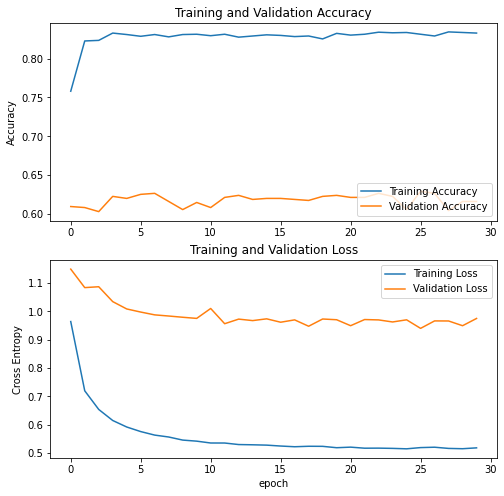

In [22]:
import pickle
history = model.fit(
          x=X_train,
          y=y_train,
          epochs=30,
          callbacks=[cp_callback],
          validation_data=(X_valid, y_valid)
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Load Best Model to Perform Prediction

In [0]:
model = tf.keras.models.load_model("drive/My Drive/checkpoints/ensemble-fc-v1/cp-0026.h5")

y_pred = model.predict(X_valid)

In [24]:
y_valid_labels = np.argmax(y_valid, axis=1) + 1
y_valid_labels

array([3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 1, 1, 1, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 3, 3, 1, 1, 2, 1,
       2, 1, 2, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 2, 3, 3, 2, 2, 3, 3, 3, 3,
       3, 3, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 3, 3,
       3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 2, 1, 3, 3, 2, 3, 3, 3, 3,
       2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 3, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1,
       1, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2,
       1, 1, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,

In [25]:
y_pred_labels = np.argmax(y_pred, axis=1) + 1
print(y_pred_labels)

[3 1 2 3 1 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 1 2 2 2 2 3 2 2 2 2 3 1 3 2
 2 3 1 1 1 1 1 1 1 3 1 1 1 1 1 2 1 3 3 2 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 3 2 3 2 1 2 1 1 1 1 1 1 1 3 1 1 1 3 1 1 1 1 2 2 2 2 2
 3 2 1 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1
 3 1 1 3 2 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 3 2 3 3 3 3 2 2 2 2 3 3 2 3 1
 3 3 3 3 1 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 1 1 2 2 2 2 2 3 2
 3 2 2 3 3 3 3 3 2 3 3 2 2 3 3 3 3 3 2 2 2 2 1 1 3 2 3 3 3 3 2 3 3 1 1 2 2
 1 1 2 1 3 1 1 3 2 2 2 3 2 2 2 2 1 1 1 2 1 1 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2
 1 2 1 1 3 2 1 1 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 3 2 1 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 3 3 2 2 3 1 1 3 1 1 1 3 2 2 2 2 3
 2 3 3 3 2 2 2 3 2 2 2 2 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3
 3 3 3 2 2 2 3 3 3 3 2 3 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Accuracy: 0.6292428198433421


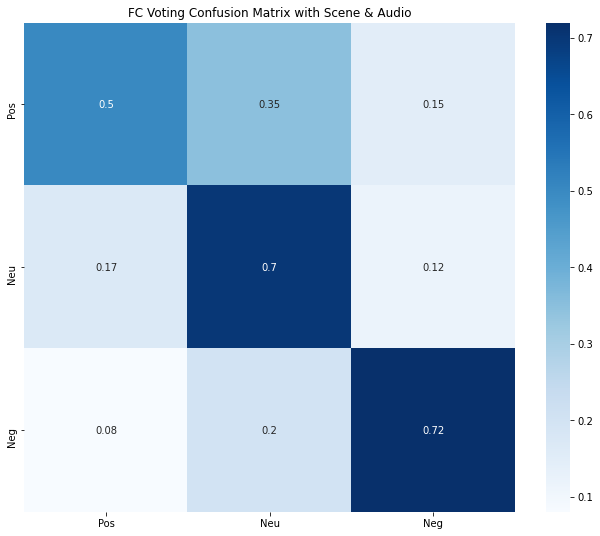

In [26]:
from sklearn import metrics 
import pandas as pd
import seaborn as sn
cm=metrics.confusion_matrix(y_valid_labels,y_pred_labels)
import matplotlib.pyplot as plt

classes=['Pos' , 'Neu' , 'Neg'] 
y_pred_final , y_true_final = y_pred_labels - 1 , y_valid_labels - 1
con_mat = tensorflow.math.confusion_matrix(labels=y_true_final, predictions=y_pred_final).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
con_mat_df = pd.DataFrame(con_mat_norm,
                  index = classes, 
                  columns = classes)

figure = plt.figure(figsize=(11, 9))
plt.title("FC Voting Confusion Matrix with Scene & Audio")
sn.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)


accuracy = (y_pred_labels == y_valid_labels).mean()
print(f"Accuracy: {accuracy}")